## 4.1 Unsupervised Learning

In [1]:
import os
import sys
import re
import csv
from tqdm import tqdm

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from utils import mask_preprocess, dice_coefficient, mask_binarize

# For controlling cell execution
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

%matplotlib inline

In [3]:
## Toggles ##

# To disable truncation for output
np.set_printoptions(threshold=sys.maxsize)

# To disable saving segmented images
save_segmented = False # change to True to download

### Local Paths

In [4]:
## Local Path ##
path = os.path.join('.', 'QC')

## Subfolders ##
train_test_path = os.path.join(path, 'split')

mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")
image_files = os.listdir(rgb_path)
image_files.sort()

### Extract Train Patient Data

In [38]:
## Obtain All Train Patients ##
train_csv = os.path.join(train_test_path, 'train_subjects.csv')
val_csv = os.path.join(train_test_path, 'validate_subjects.csv')


# Read all patients as list
with open(train_csv, newline='') as f:
    reader = csv.reader(f)
    train_subjects = list(reader)

train_subjects = train_subjects[1:] # remove "Patient id"

## Validation
with open(val_csv, newline='') as f:
    reader = csv.reader(f)
    val_subjects = list(reader)

val_subjects = val_subjects[1:]


## Create Train Patient List ##
train_data = []
for patient in train_subjects:
    for file in image_files:
        if re.match(patient[0], file):
            train_data.append(file)

## Create Val Patient List ##
val_data = []
for patient in val_subjects:
    for file in image_files:
        if re.match(patient[0], file):
            val_data.append(file)

### Define K Mean

In [8]:
def KMean(image_name, k, download):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2RGB)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1,3))
    image = np.float32(image)
    # plt.imshow(image)

    # Define criteria for termination: 100 iterations or 100 accuracy
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)

    # Perform K Means
    _, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))


    # Switch
    if download == True:
        return segmented_image
    else:
        # Plot the segmented image
        plt.imshow(segmented_image)

### Segment All Train Images
**Caution:** this block will create a new folder

In [53]:
%%skip_if save_segmented == False

# make folder for split
segmented_path = os.path.join(path, 'unsupervised_segmented_train')
os.makedirs(segmented_path, exist_ok=True)

for file in train_data:
    destination = os.path.join(segmented_path, file)
    img = KMean(file, 2, True)
    cv.imwrite(destination, img)

#### Find Optimized k Value
* k = 2
* k = 3
* k = 5
* Compute Dice coefficient

Text(0.5, 0.98, 'Tester Image Segmented with K Mean Clustering Algorithm')

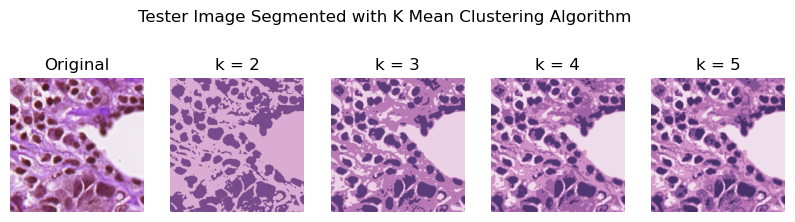

In [9]:
tester = 'TCGA-A2-A0SX-DX1_id-5ea40b05ddda5f839899743b_left-56081_top-57443_bottom-57731_right-56368.png'

k2 = KMean(tester, 2, True)
k3 = KMean(tester, 3, True)
k4 = KMean(tester, 4, True)
k5 = KMean(tester, 5, True)

plt.figure(figsize=(10, 2.8))
plt.subplot(1, 5, 1)
im = cv.imread(os.path.join(rgb_path, tester))
plt.imshow(im)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(k2)
plt.title("k = 2")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(k3)
plt.title("k = 3")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(k4)
plt.title("k = 4")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(k5)
plt.title("k = 5")
plt.axis("off")

plt.suptitle('Tester Image Segmented with K Mean Clustering Algorithm')

(-0.5, 354.5, 356.5, -0.5)

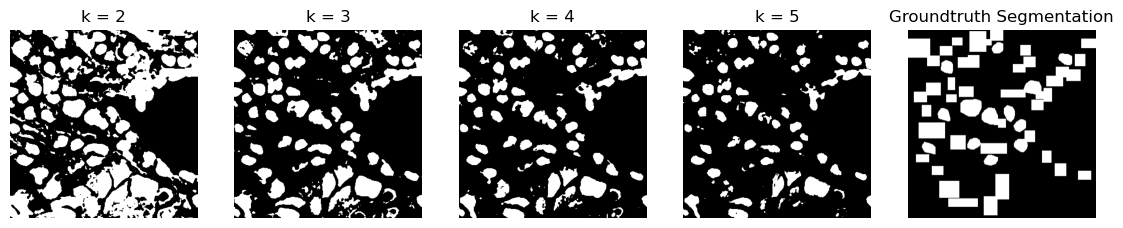

In [10]:
## Binarized Version ##
k2_b = mask_binarize(k2)
# k2_b = cv.morphologyEx(k2_b, cv.MORPH_CLOSE, (5,5), iterations=3)
k3_b = mask_binarize(k3)
k4_b = mask_binarize(k4)
# k3_b = cv.morphologyEx(k3_b, cv.MORPH_CLOSE, (5,5), iterations=3)
k5_b = mask_binarize(k5)
# k5_b = cv.morphologyEx(k5_b, cv.MORPH_CLOSE, (5,5), iterations=3)

_, mask = mask_preprocess(tester, mask_path)
mask = cv.resize(mask, (k2_b.shape[1], k2_b.shape[0]))

plt.figure(figsize=(14, 3.25))
plt.subplot(1, 5, 1)
plt.imshow(k2_b, cmap='gray')
plt.title("k = 2")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(k3_b, cmap='gray')
plt.title("k = 3")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(k4_b, cmap='gray')
plt.title("k = 4")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(k5_b, cmap='gray')
plt.title("k = 5")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(mask, cmap='gray')
plt.title("Groundtruth Segmentation")
plt.axis("off")

#### Compute Dice Coefficient
$$ dice =  \frac{2(A\cap B)}{A+B} $$

A+B can be obtained by:
$$ A+B = (A\cup B) + (A\cap B) $$

In [115]:
# K = 2
dice = dice_coefficient(mask, k2_b)
print(f'Dice Score for k=2 is {dice}')

# K = 3
dice = dice_coefficient(mask, k3_b)
print(f'Dice Score for k=3 is {dice}')

# K = 4
dice = dice_coefficient(mask, k4_b)
print(f'Dice Score for k=4 is {dice}')

# K = 5
dice = dice_coefficient(mask, k5_b)
print(f'Dice Score for k=5 is {dice}')

Dice Score for k=2 is 0.572003683108557
Dice Score for k=3 is 0.6124167681639864
Dice Score for k=4 is 0.581770267532277
Dice Score for k=5 is 0.5328414411237083


#### Use Grayscale Image ####

Dice Score for k=2 is 0.5401889107778166
Dice Score for k=3 is 0.6052286777815797
Dice Score for k=4 is 0.5788843031715468
Dice Score for k=5 is 0.5208903676268715


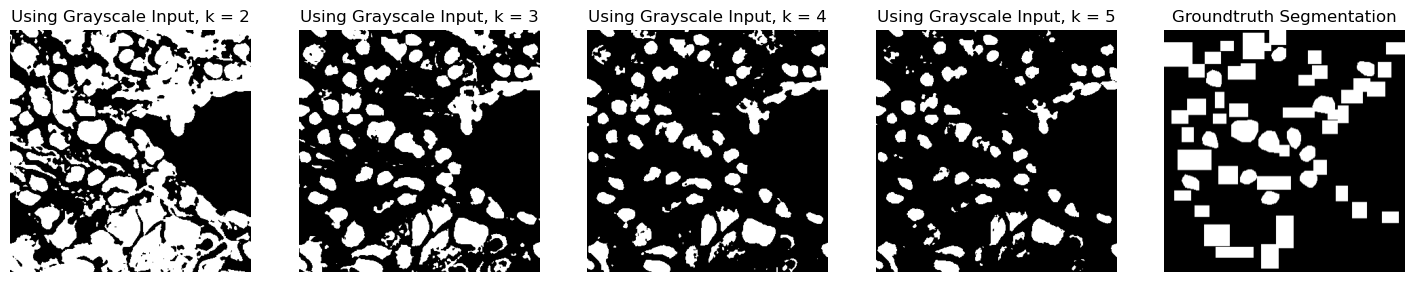

In [41]:
def KMean_gray(image_name, k, download):
    image = cv.cvtColor(cv.imread(os.path.join(rgb_path, image_name)), cv.COLOR_BGR2GRAY)
    original_image = image.copy()

    # Convert to 2D rgb array and float type
    image = image.reshape((-1))
    image = np.float32(image)
    # plt.imshow(image)

    # Define criteria for termination: 100 iterations or 100 accuracy
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 1.0)

    # Perform K Means
    _, labels, centers = cv.kmeans(image, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((original_image.shape))


    # Switch
    if download == True:
        return segmented_image
    else:
        # Plot the segmented image
        plt.imshow(segmented_image)

tester = 'TCGA-A2-A0SX-DX1_id-5ea40b05ddda5f839899743b_left-56081_top-57443_bottom-57731_right-56368.png'
k2 = KMean_gray(tester, 2, True)
k3 = KMean_gray(tester, 3, True)
k4 = KMean_gray(tester, 4, True)
k5 = KMean_gray(tester, 5, True)

## Binarize Mask for Dice ##
k2_b = mask_binarize(k2)
k3_b = mask_binarize(k3)
k4_b = mask_binarize(k4)
k5_b = mask_binarize(k5)

## Visualize ##
plt.figure(figsize=(18, 3.25))
plt.subplot(1, 5, 1)
plt.imshow(k2_b, cmap='gray')
plt.title("Using Grayscale Input, k = 2")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(k3_b, cmap='gray')
plt.title("Using Grayscale Input, k = 3")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(k4_b, cmap='gray')
plt.title("Using Grayscale Input, k = 4")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(k5_b, cmap='gray')
plt.title("Using Grayscale Input, k = 5")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(mask, cmap='gray')
plt.title("Groundtruth Segmentation")
plt.axis("off")

_, mask = mask_preprocess(tester, mask_path)
mask = cv.resize(mask, (k2_b.shape[1], k2_b.shape[0]))

# K = 2
dice = dice_coefficient(mask, k2_b)
print(f'Dice Score for k=2 is {dice}')

# K = 3
dice = dice_coefficient(mask, k3_b)
print(f'Dice Score for k=3 is {dice}')

# K = 4
dice = dice_coefficient(mask, k4_b)
print(f'Dice Score for k=4 is {dice}')

# K = 5
dice = dice_coefficient(mask, k5_b)
print(f'Dice Score for k=5 is {dice}')

### Over Entire Dataset

In [103]:
def dice_complete(max_k):
    if max_k < 2:
        print("max_k cannot be under 2!")

    length = len(image_files)
    dice_score = {}
    dice_score_g = {}
    for filename in tqdm(image_files):
        _, mask = mask_preprocess(filename, mask_path)

        for i in range(2, max_k+1):
            k = KMean(filename, i, True)
            k_g = KMean_gray(filename, i, True)
            mask = cv.resize(mask, (k.shape[1], k.shape[0]))

            ## Binarize Mask for Dice ##
            # rgb
            k_b = mask_binarize(k)
            # gray
            k_g_b = mask_binarize(k_g)

            ## Measure Dice Score ##
            dice = dice_coefficient(mask, k_b)
            if i in dice_score.keys():
                dice_score[i][0] += dice / length
            else:
                dice_score[i] = [dice / length]
            # print(f'Dice Score for k={i} is {dice}')
            dice2 = dice_coefficient(mask, k_g_b)
            if i in dice_score_g.keys():
                dice_score_g[i] += dice2 / length
            else:
                dice_score_g[i] = [dice2 / length]
            # print(f'Dice Score for k={i} Grayscale is {dice2}')

    return dice_score, dice_score_g

d1, d2 = dice_complete(5)


100%|██████████| 1744/1744 [1:23:23<00:00,  2.87s/it]


In [104]:
print(d1)
print(d2)

{2: [0.4594696841594485], 3: [0.4973870397732267], 4: [0.46843111226141165], 5: [0.4232400477834124]}
{2: array([0.45054581]), 3: array([0.49328017]), 4: array([0.47100749]), 5: array([0.42970968])}


#### Over Val Dataset

In [42]:
def dice_complete(max_k):
    if max_k < 2:
        print("max_k cannot be under 2!")

    length = len(val_data)
    dice_score = {}
    dice_score_g = {}
    for filename in tqdm(val_data):
        _, mask = mask_preprocess(filename, mask_path)

        for i in range(2, max_k+1):
            k = KMean(filename, i, True)
            k_g = KMean_gray(filename, i, True)
            mask = cv.resize(mask, (k.shape[1], k.shape[0]))

            ## Binarize Mask for Dice ##
            # rgb
            k_b = mask_binarize(k)
            # gray
            k_g_b = mask_binarize(k_g)

            ## Measure Dice Score ##
            dice = dice_coefficient(mask, k_b)
            if i in dice_score.keys():
                dice_score[i][0] += dice / length
            else:
                dice_score[i] = [dice / length]
            # print(f'Dice Score for k={i} is {dice}')
            dice2 = dice_coefficient(mask, k_g_b)
            if i in dice_score_g.keys():
                dice_score_g[i] += dice2 / length
            else:
                dice_score_g[i] = [dice2 / length]
            # print(f'Dice Score for k={i} Grayscale is {dice2}')

    return dice_score, dice_score_g

d1, d2 = dice_complete(5)


100%|██████████| 363/363 [16:35<00:00,  2.74s/it]


In [44]:
print(d1)
print(d2)

{2: [0.4762969698937455], 3: [0.5095393988735494], 4: [0.47002274979186875], 5: [0.4199990077949967]}
{2: array([0.46383015]), 3: array([0.50557627]), 4: array([0.47445971]), 5: array([0.42886415])}


### Mean Shift

Dice Score for Mean Shift Segmentation 0.569754730265802


Text(0.5, 1.0, 'Binary Optimal KMean, k=3')

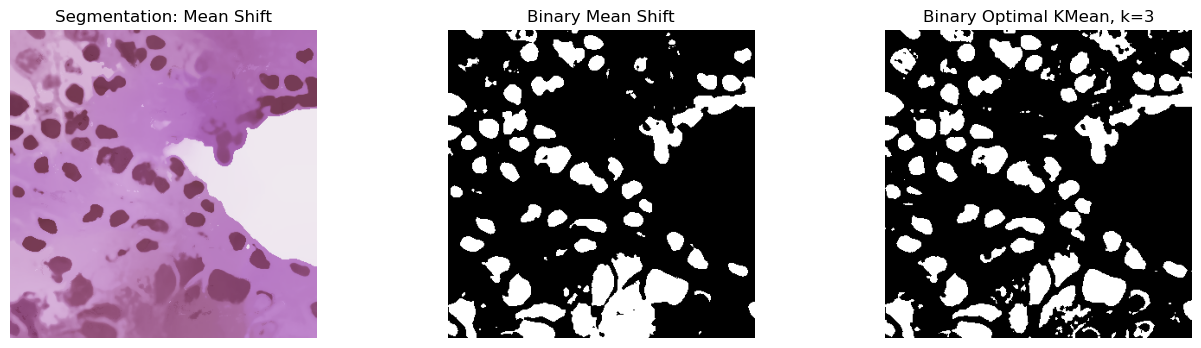

In [34]:
tester = 'TCGA-A2-A0SX-DX1_id-5ea40b05ddda5f839899743b_left-56081_top-57443_bottom-57731_right-56368.png'

def meanShift(image_name):
    img = cv.imread(os.path.join(rgb_path, image_name), cv.COLOR_BGR2RGB)
    output = img.copy()
    # preprocess - gaussian 
    img = cv.GaussianBlur(img, (5, 5), 0.85)
    # define params
    spatialWindow = 40
    colorWindow = 80
    
    # meanshift clustering
    cv.pyrMeanShiftFiltering(img, spatialWindow, colorWindow, output, maxLevel=0)
    return output

# mean shift segmentation, binarize   
ms = meanShift(tester)
msGray = cv.cvtColor(ms, cv.COLOR_RGB2GRAY)
_, msB = cv.threshold(msGray, 125, 255, cv.THRESH_BINARY_INV)

## Preprocess Mask ##
_, mask = mask_preprocess(tester, mask_path)
mask = cv.resize(mask, (msB.shape[1], msB.shape[0]))

# compare to mask
dice = dice_coefficient(mask, msB)
print(f'Dice Score for Mean Shift Segmentation {dice}')

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(ms)
plt.title('Segmentation: Mean Shift')
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(msB, cmap='gray')
plt.title('Binary Mean Shift')
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(k3_b, cmap='gray')
plt.title('Binary Optimal KMean, k=3')

#### Over Validation Dataset

In [45]:
def mean_shift_dice_complete():
    length = len(val_data)
    avg_dice_score = 0
    for filename in tqdm(val_data):
        ms = meanShift(filename)
        msGray = cv.cvtColor(ms, cv.COLOR_RGB2GRAY)
        _, msB = cv.threshold(msGray, 125, 255, cv.THRESH_BINARY_INV)

        ## Preprocess Mask ##
        _, mask = mask_preprocess(tester, mask_path)
        mask = cv.resize(mask, (msB.shape[1], msB.shape[0]))

        # compare to mask
        dice = dice_coefficient(mask, msB)
        # print(f'Dice Score for Mean Shift Segmentation {dice}')
        avg_dice_score += dice
    return avg_dice_score / length

d1 = mean_shift_dice_complete()


100%|██████████| 363/363 [1:13:26<00:00, 12.14s/it]


In [46]:
print(d1)

0.22543542743462197
